In [2]:
import pandas as pd

X = pd.read_csv('rotatingHyperplane.data', sep=' ', header=None)
y = pd.read_csv('rotatingHyperplane.labels', header=None)

Wczytujemy dane, następnie wybieramy z nich zbiór najwcześniejszych i najpóźniejszych wierszy, które to niezależnie dzielimy na zbiory treningowe i testowe

In [3]:
from sklearn.model_selection import train_test_split

early_X = X.loc[:len(X) / 10]
early_y = y.loc[:len(y) / 10]

late_X = X.loc[9 * len(X) / 10:]
late_y = y.loc[9 * len(y) / 10:]

early_X_train, early_X_test, early_y_train, early_y_test = train_test_split(early_X, early_y, test_size=0.25, shuffle=True)
late_X_train, late_X_test, late_y_train, late_y_test = train_test_split(late_X, late_y, test_size=0.25, shuffle=True)

Na każdym ze zbiorów treningowych budujemy model regresji logistycznej

In [4]:
from sklearn.linear_model import LogisticRegression

log_reg_early = LogisticRegression()
log_reg_late = LogisticRegression()

log_reg_early.fit(early_X_train, early_y_train)
log_reg_late.fit(late_X_train, late_y_train)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Definiujemy użyteczne funkcje

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def histogram_intersection(h1, h2, bins):
    bins = np.diff(bins)
    sm = 0
    for i in range(len(bins)):
        sm += min(bins[i] * h1[i], bins[i] * h2[i])
    return sm

def plot_histogram_calc_intersection(data1, data2, num_bins, value_range, title):
    h1, bins= np.histogram(data1, bins=num_bins, range=value_range, density=True)
    h2, _ = np.histogram(data2, bins=num_bins, range=value_range, density=True)
    intersection = histogram_intersection(h1, h2, bins)
#     plt.hist(data1, bins=bins, label='early', alpha=0.5)
#     plt.hist(data2, bins=bins, label='late', alpha=0.5)
    sns.distplot(data1, bins=bins, label='early')
    sns.distplot(data2, bins=bins, label='late')
    plt.title(f"{title} - Intersection: {intersection}")
    plt.legend()
    plt.show()
    return intersection

In [60]:
def PD_plot(model, data, column, num_of_intervals):
    x_values = np.linspace(data[column].min(), data[column].max(), num_of_intervals + 1)
    y_values = []
    for x in x_values:
        data_cpy = data.copy()
        data_cpy[column] = x
        y = model.predict_proba(data_cpy)[:, 1].mean()
        y_values.append(y)
    return x_values, y_values

In [71]:
def area(x, y1, y2):
    return np.sum(np.abs(np.array(y1) - np.array(y2))) / (len(x) - 1)

def PD_plot_for_two_models_and_area(model1, data1, model2, data2, column, num_of_intervals, title):
    x1, y1 = PD_plot(model1, data1, column, 100)
    x2, y2 = PD_plot(model2, data2, column, 100)
    area_between = area(x1, y1, y2)
    plt.plot(x1, y1, label='early')
    plt.plot(x2, y2, label='late')
    plt.fill_between(x1, y1, y2,
                    where=[True if v1 >= v2 else False for v1, v2 in zip(y1, y2)],
                     facecolor='blue', alpha=0.5)
    plt.fill_between(x1, y1, y2,
                    where=[True if v1 < v2 else False for v1, v2 in zip(y1, y2)],
                    facecolor='orange', alpha=0.5)
    plt.title(f"{title} - Area: {area_between}")
    plt.legend()
    plt.show()

Badamy rozkład każdej zmiennej w zbiorze najwcześniejszym i najpóźniejszym. Dostrzegamy, że ich rozkłady są bardzo podobne - wskazują na to histogramy, empiryczna gęstość i duża wartość intersection.

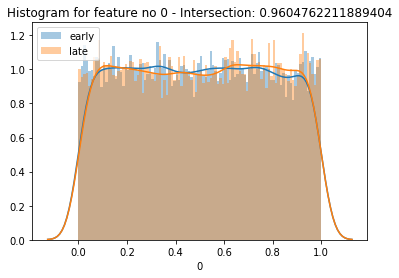

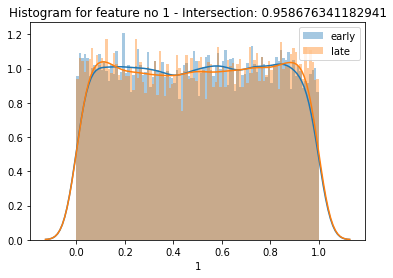

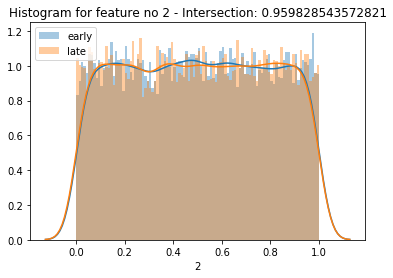

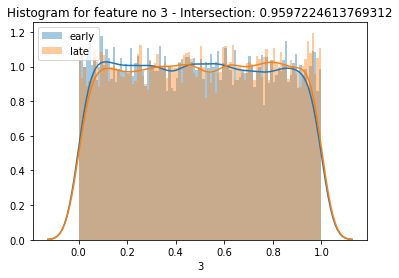

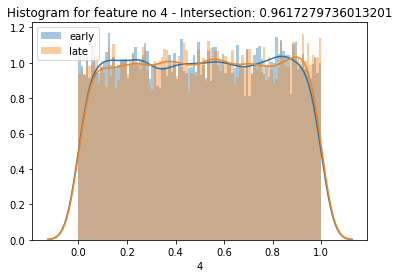

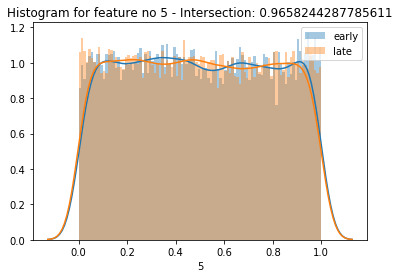

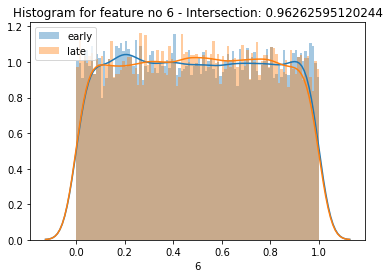

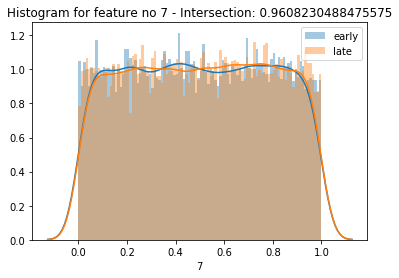

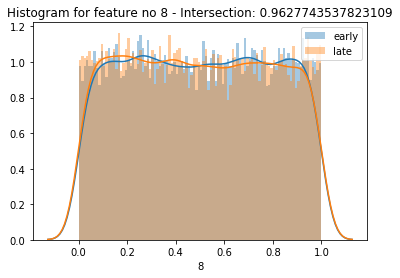

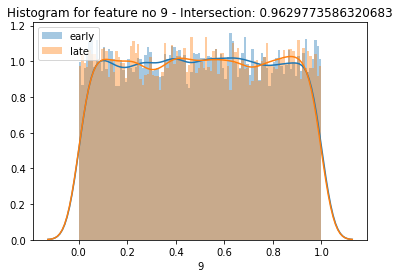

In [72]:
intersections = {}
for col in early_X.columns:
    intersections[col] = plot_histogram_calc_intersection(early_X[col], late_X[col], 100, (0, 1),
                                                          f"Histogram for feature no {col}")

Podsumowanie wartości intersection - jak widzimy wszystkie zmienne mają intersection bliskie maksymalnej wartości 1.

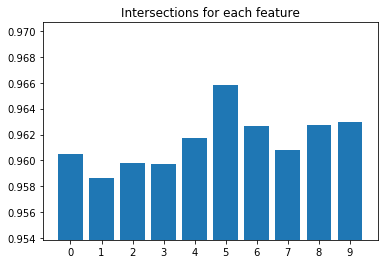

In [49]:
plt.bar(range(len(intersections)), intersections.values())
plt.xticks(range(len(intersections)), intersections.keys())
plt.ylim(min(intersections.values()) - 0.005 * min(intersections.values()),
         max(intersections.values()) + 0.005 * max(intersections.values()))
plt.title('Intersections for each feature')
plt.show()

In [43]:
pred_early_log_reg_on_early_data = log_reg_early.predict_proba(early_X_test)[:, 1]
pred_early_log_reg_on_late_data = log_reg_early.predict_proba(late_X_test)[:, 1]

pred_late_log_reg_on_early_data = log_reg_late.predict_proba(early_X_test)[:, 1]
pred_late_log_reg_on_late_data = log_reg_late.predict_proba(late_X_test)[:, 1]

residuals_early_log_reg_on_early_data = pred_early_log_reg_on_early_data - early_y_test.values.reshape(-1)
residuals_early_log_reg_on_late_data = pred_early_log_reg_on_late_data - late_y_test.values.reshape(-1)

residuals_late_log_reg_on_early_data = pred_late_log_reg_on_early_data - early_y_test.values.reshape(-1)
residuals_late_log_reg_on_late_data = pred_late_log_reg_on_late_data - late_y_test.values.reshape(-1)

Badamy rozkład i intersection dla reszt predykcji. Jak widzimy modele wytrenowane na danych ze znacznie oddalonych w czasie okresów sprawdzają się znacznie lepiej na danych z okresu, na którym były trenowane niż dla danych odległych. Widzimy to zarówno obserwując histogramy jak i wartość intersection, która jest dość odległa od maksymalnej wartości 1. Jednoznacznie wskazuje to na dryft w danych.

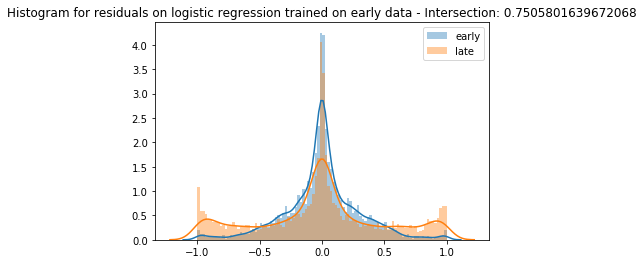

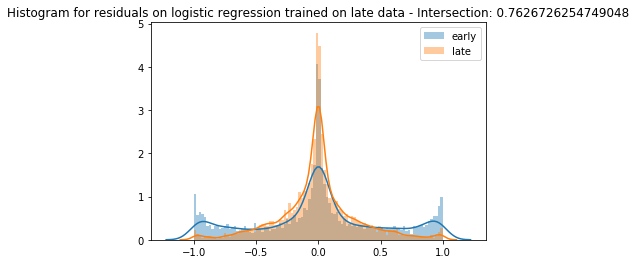

0.7626726254749048

In [54]:
plot_histogram_calc_intersection(residuals_early_log_reg_on_early_data, residuals_early_log_reg_on_late_data,
                                 100, (-1, 1), f"Histogram for residuals on logistic regression trained on early data")

plot_histogram_calc_intersection(residuals_late_log_reg_on_early_data, residuals_late_log_reg_on_late_data,
                                 100, (-1, 1), f"Histogram for residuals on logistic regression trained on late data")

Dla każdego parametru liczymy pole między krzywymi pdp w modelu dla danych najwcześniejszych i najpóźniejszych. Zauważamy, że pewne parametery mają zdecydowanie większe obliczone pole niż pozostałe. To właśnie parametry o dużej różnicy między krzywymi pdp powodują zaobserowony wyżej dryft, gdyż to one najistotniej zmieniają się w czasie.

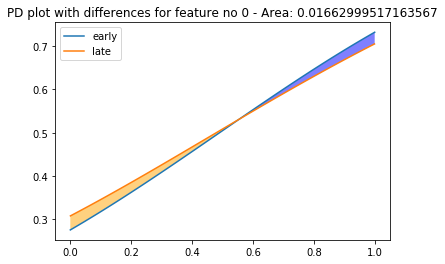

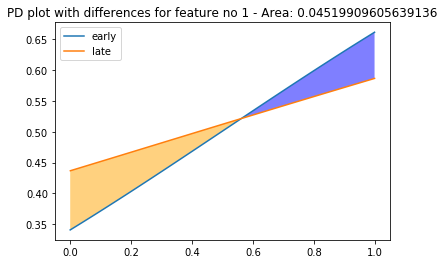

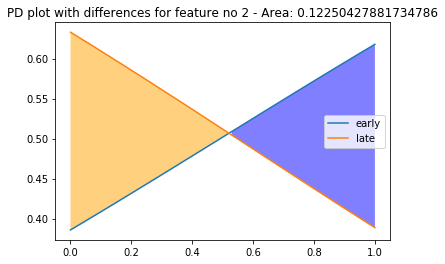

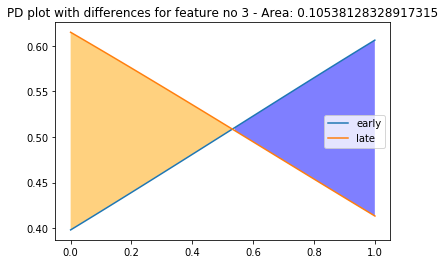

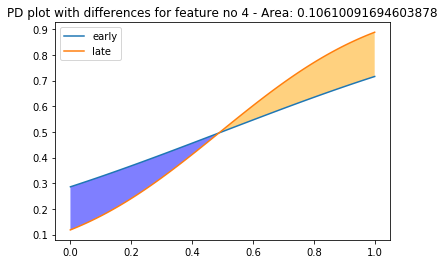

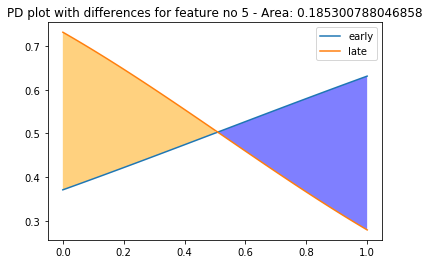

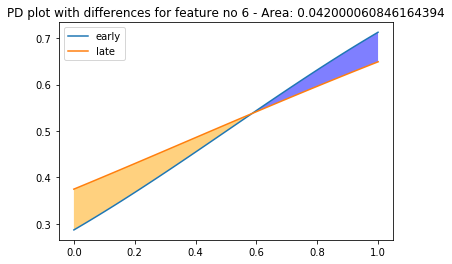

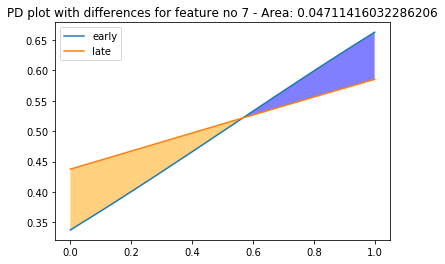

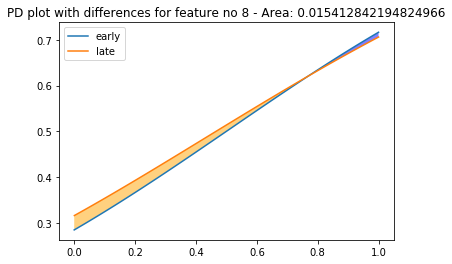

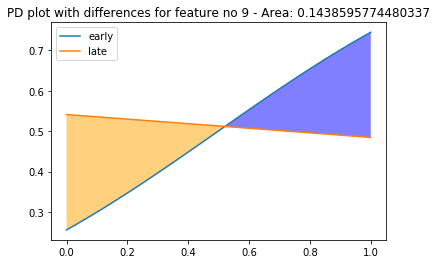

In [74]:
for col in early_X_test.columns:
    PD_plot_for_two_models_and_area(log_reg_early, early_X_test, log_reg_late, late_X_test, col, 100, 
                                   f"PD plot with differences for feature no {col}")